## Training vision transformer on MNIST dataset

In [1]:
from implementation import VisionTransformer
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pytorch_lightning as L
import torch.nn.functional as F
import torch
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import torchvision 
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  
    transforms.ToTensor(),
])

train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_data = datasets.MNIST(root="./data", train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(test_data, batch_size=64, num_workers=0)

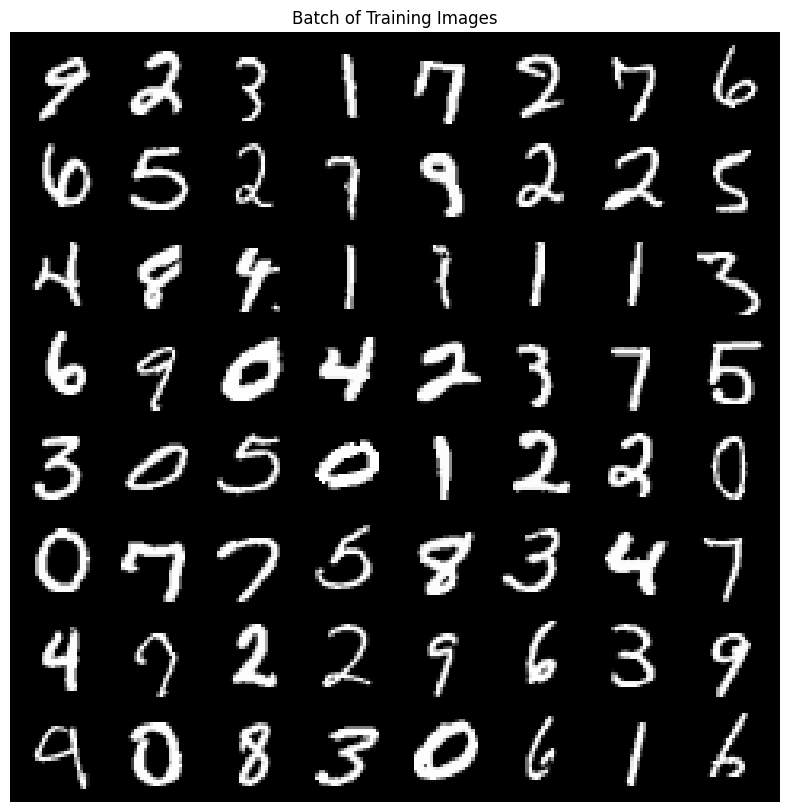

In [3]:
def show_batch(data_loader):
    batch = next(iter(data_loader))
    images, labels = batch
    grid = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title("Batch of Training Images")
    plt.axis('off')
    plt.show()

show_batch(train_loader)

In [4]:
vit_model = VisionTransformer(
    image_size=28,
    patch_size=7,             
    num_channels=1,          
    hidden_size=64,
    num_heads=4,
    num_layers=4,
    mlp_dim=128,
    dropout_prob=0.1,
    num_classes=10           
)

In [5]:
class LitViT(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [6]:
import warnings
warnings.filterwarnings("ignore", message=".*does not have many workers.*")

trainer = Trainer(
    max_epochs=10,
    accelerator="cpu",
    logger=False,               
    enable_checkpointing=False,
    enable_progress_bar=True,
    enable_model_summary=False
)

lit_model = LitViT(vit_model)

trainer.fit(lit_model, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 9: 100%|██████████| 938/938 [01:12<00:00, 12.91it/s, train_loss=0.0196, train_acc=1.000, val_loss=0.0784, val_acc=0.977] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 938/938 [01:12<00:00, 12.91it/s, train_loss=0.0196, train_acc=1.000, val_loss=0.0784, val_acc=0.977]



In [7]:
def evaluate(model, data_loader, loss_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(model.device), target.to(model.device)
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum().item()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: {:.4f}  Accuracy: {}/{} ({:.2f}%)\n'.format(
        avg_loss, correct_samples, total_samples, 100.0 * correct_samples / total_samples
    ))

In [8]:
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(model.device)
            output = model(data)
            _, preds = torch.max(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


Average test loss: 0.0784  Accuracy: 9774/10000 (97.74%)



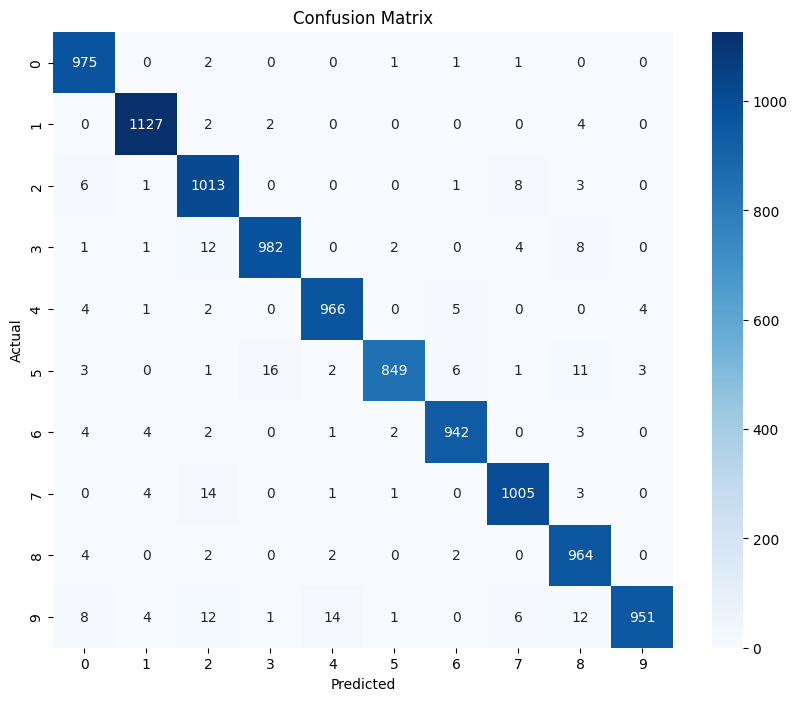

In [9]:
loss_history = []
evaluate(lit_model, val_loader, loss_history)
plot_confusion_matrix(lit_model, val_loader)